In [1]:
import os, logging, pickle, logging
import tensorflow as tf
import numpy as np
import time
from utils import random_batch, normalize, similarity, loss_cal, optim
from configuration import get_config
from tensorflow.contrib import rnn

config = get_config()

Namespace(M=5, N=4, beta1=0.5, beta2=0.9, comment='', hidden=768, hop=0.01, iteration=100000, loss='softmax', lr=0.01, max_batch_utterances=1000, model_num=6, model_path='./tisv_model', nfft=512, noise_filenum=16, noise_path='/datadrive2/dalon/diarization-experiments/Speaker_Verification/data/VCTK-Corpus/noise', num_layer=3, optim='sgd', proj=256, restore=False, sr=8000, tdsv=False, tdsv_frame=80, test_path='/datadrive2/dalon/diarization-experiments/Speaker_Verification/data/VCTK-Corpus/test', tisv_frame=50, train=False, train_path='/datadrive2/dalon/diarization-experiments/Speaker_Verification/data/VCTK-Corpus/train', window=0.025)


In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt

log_file = os.path.abspath("dataprep-phase2.logs")
logging.basicConfig(
    filename=log_file,
    level=logging.DEBUG,
    format="%(asctime)s:%(levelname)s:%(message)s"
    )
print(f'Log path: {log_file}')

%matplotlib inline

Log path: /datadrive2/dalon/diarization-experiments/Speaker_Verification/Notebooks/dataprep-phase2.logs


# Data selection

Roughly in dev set:

Voxceleb 2</br >
Number of speakers = 5,994

Voxceleb 1</br >
Number of speakers = 1,211

In [3]:
# Voxceleb-1 structure
# [['/datadrive2/dalon/diarization-experiments/voxceleb-dataset/voxceleb-1/wav/id10266/SHI6yGzrwLg/00001.wav',
#   '/datadrive2/dalon/diarization-experiments/voxceleb-dataset/voxceleb-1/cleaned-data/id10266/SHI6yGzrwLg/00001.npy',
#   (12, 40, 50)],
# voxceleb1_file_list[:2]

In [4]:
# # Voxceleb1 distribution
# voxceleb1_file_path = "/datadrive2/dalon/diarization-experiments/voxceleb-dataset/voxceleb-1/voxceleb-1.b"
# voxceleb1_file_list = np.load(voxceleb1_file_path)
# voxceleb1_clean_list = [[x[1], int(x[2][0])] for x in voxceleb1_file_list if x[2][0] != 0]
# voxceleb1_size_list = np.array([x[1] for x in voxceleb1_clean_list])
# print(f'Total # of Utterances = {len(voxceleb1_size_list)}')
# print(f'Max = {voxceleb1_size_list.max()}\nMin = {voxceleb1_size_list.min()}\nMean = {voxceleb1_size_list.mean()}')

In [5]:
# Check the data distribution
data_path = "/datadrive2/dalon/diarization-experiments/voxceleb-dataset/voxceleb-2/voxceleb-2-train-v1.b"
save_dir = f"/datadrive2/dalon/diarization-experiments/voxceleb-dataset/voxceleb-2/train-data-pruned-{config.max_batch_utterances}"
os.makedirs(save_dir)

In [6]:
with open(data_path, "rb") as f:
    train_data_paths = pickle.load(f)

In [7]:
train_data_paths[:2]

[['/datadrive2/dalon/diarization-experiments/voxceleb-dataset/voxceleb-2/train-data-v1/id00421.npy',
  (2571, 40, 50)],
 ['/datadrive2/dalon/diarization-experiments/voxceleb-dataset/voxceleb-2/train-data-v1/id04835.npy',
  (1112, 40, 50)]]

In [8]:
number_of_segments = np.array([x[1][0] for x in train_data_paths])

In [11]:
logging.info(f'Total Number of Speakers: {len(number_of_segments)}')
logging.info(f'Max = {number_of_segments.max()}\nMin = {number_of_segments.min()}\nMean = {number_of_segments.mean()}')

(array([442., 622., 568., 469., 422., 353., 289., 259., 221., 222.]),
 array([ 125. ,  312.5,  500. ,  687.5,  875. , 1062.5, 1250. , 1437.5,
        1625. , 1812.5, 2000. ]),
 <a list of 10 Patch objects>)

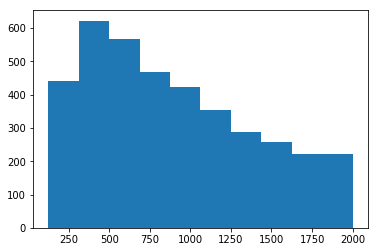

In [13]:
plt.hist(number_of_segments[number_of_segments <= 2000])

In [14]:
number_of_segments[number_of_segments == 0]

array([], dtype=int64)

In [ ]:

# read the features
max_batch_utterances = config.max_batch_utterances
for idx, entry in enumerate(train_data_paths):
    logging.info(f'Processing: {idx + 1}/{len(number_of_segments)}')
    data = np.load(entry[0])
    if data.shape[0] >= max_batch_utterances:
        data = data[:max_batch_utterances, :, :]
    elif data.shape[0] < max_batch_utterances:
        data = np.pad(data,((0, max_batch_utterances - data.shape[0]), (0, 0), (0, 0)), 'wrap')
    speaker = os.path.splitext(entry[0].split("/")[-1])[0]
    logging.info(f'{data.shape}')
    logging.info(f'Saving: {os.path.join(save_dir, speaker + ".npy")}')
    np.save(os.path.join(save_dir, speaker + '.npy'), data)
logging.info("Completed!")


In [ ]:

def random_batch(speaker_num=config.N, utter_num=config.M, shuffle=True, noise_filenum=None, utter_start=0):
    """ Generate 1 batch.
        For TD-SV, noise is added to each utterance.
        For TI-SV, random frame length is applied to each batch of utterances (140-180 frames)
        speaker_num : number of speaker of each batch
        utter_num : number of utterance per speaker of each batch
        shuffle : random sampling or not
        noise_filenum : specify noise file or not (TD-SV)
        utter_start : start point of slicing (TI-SV)
    :return: 1 random numpy batch (frames x batch(NM) x n_mels)
    """

    np_file_list = os.listdir(path)
    total_speaker = len(np_file_list)

    if shuffle:
        selected_files = random.sample(np_file_list, speaker_num)  # select random N speakers (default N=4)
    else:
        selected_files = np_file_list[:speaker_num]                # select first N speakers

    utter_batch = []
    for file in selected_files:
        utters = np.load(os.path.join(path, file))        # load utterance spectrogram of selected speaker
        if shuffle:
            utter_index = np.random.randint(0, utters.shape[0], utter_num)   # select M utterances per speaker (default M=5)
            utter_batch.append(utters[utter_index])       # each speakers utterance [M, n_mels, frames] is appended
        else:
            utter_batch.append(utters[utter_start: utter_start+utter_num])

    utter_batch = np.concatenate(utter_batch, axis=0)     # utterance batch [batch(NM), n_mels, frames]
a
    frame_slice = np.random.randint(140,181)          # for train session, random slicing of input batch
    utter_batch = utter_batch[:,:,:frame_slice]

    utter_batch = np.transpose(utter_batch, axes=(2,0,1))     # transpose [frames, batch, n_mels]

    return utter_batch
